Implementations

In [1]:
from implementations import *
from helpers import *
import matplotlib.pyplot as plt
import numpy as np
from functions import *

# 1- Load data

In [ ]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data('dataset_to_release/', sub_sample=False)

# 2- Clean data

Presence of duplicata :  False


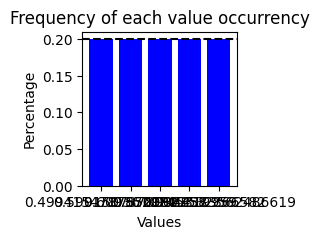

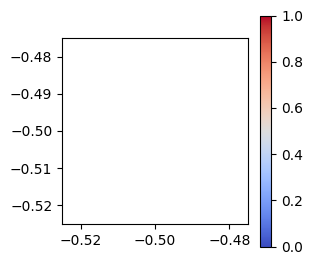

Finale shape of x_train :  (5, 1)
Finale shape of y_train :  (5,)
Finale shape of x_test :  (5, 1)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [11]:
#check if duplicates in x_train
duplicata(x_train)    

#shuffle x_train and y_train at the same time to shuffle them in the same way
x_train1, y_train1 = shuffle_rows (x_train, y_train)

#check the distribution of sick and not sick
test_balancy_dataset(y_train1)
    
#premiere colonne remplie de Nan (supprimer d autres des premieres colonnes)
x_train1 = x_train1[:,9:]
x_test1 = x_test[:,9:]

#remplacer Nan par mediane (estce qu on a le droit de faire ca dans xtest? estce que cest une bonne idee ?)
x_train1=nan_to_median(x_train1)
x_test1=nan_to_median(x_test1)

#enlever les lignes d outliers pour chaque colonne
#x_train1, y_train1 = remove_outliers(x_train1, y_train1, threshold=0.000002)

#standardization of test
x_test1, _ = standardize_(x_test1)

#enlever les colonnes qui ont une std nulle
x_train1, col_to_keep=remove_zero_std_columns(x_train1)
x_test1= x_test1[:, col_to_keep]

#enlever les colonnes avec trop grande correlation
x_train1, col_to_delete=remove_high_correlation_feature(x_train1)
x_test1= np.delete(x_test1, col_to_delete, axis = 1)

#recuperer les indices des colomnes numeriques et categoriques (au dessus de 5 valeurs diff on considere numerical)
categorical_columns, numeric_columns, _, _=separate_column_types(x_train1, max_nb=5)

#dans les colonnes numeriques, supprimer les lignes correspondant à des outliers
x_train1, y_train1=remove_numerical_outliers(x_train1, y_train, numeric_columns, z_threshold=3)

#enlever les lignes de outliers
#x_train1, rows_to_keep =remove_outlier_rows(x_train1)

#remplacer les outliers dans les colonnes qu'il reste avec la medianne aussi (le faire pour x_test?)
#x_train1=replace_remaining_outlier_values(x_train1)
#x_test1 = replace_remaining_outlier_values(x_test1)

#Add a column of ones
x_train1 = build_model_data(x_train1)
x_test1 = build_model_data(x_test1)

print('Finale shape of x_train : ', x_train1.shape)
print('Finale shape of y_train : ', y_train1.shape)
print('Finale shape of x_test : ', x_test1.shape)
print(x_train1)

### Dividing the dataset in balanced subsets 

In [ ]:
nb_ones = np.count_nonzero(y_train1 == 1)  #28 975 sick people in y_train
nb_subsets = np.round( x_train.shape[0] / nb_ones, 0) #11 groups

indices_ones = np.argwhere(y_train1 == 1)
x_train_ones = x_train1[indices_ones]
x_train_ones_ = np.squeeze(x_train_ones, axis=1)#Enleve une dimension en trop
y_train_ones = y_train1[indices_ones]
y_train_ones_ = np.squeeze(y_train_ones, axis = 1)

indices_minus_ones = np.argwhere(y_train1 == -1)
x_train_minus_ones = x_train1[indices_minus_ones]
x_train_minus_ones_ = np.squeeze(x_train_minus_ones, axis=1) #Enleve une dimension en trop
y_train_minus_ones = y_train1[indices_minus_ones]

split_x_train_minus_ones = np.array_split(x_train_minus_ones, nb_subsets)  # 11 groups of 27 197 or 27 196 people
split_y_train_minus_ones = np.array_split(y_train_minus_ones, nb_subsets)

balanced_x_train = [] #List of 11 x_train
balanced_y_train = [] #List of 11 y_train

for i in range(len(split_x_train_minus_ones)):
    together_x = np.concatenate((split_x_train_minus_ones[i], x_train_ones), axis=0)
    together_x = np.squeeze(together_x, axis=1)
    
    together_y = np.concatenate((split_y_train_minus_ones[i], y_train_ones), axis = 0)
    together_y = np.squeeze(together_y, axis=1)
    
    balanced_x_train.append(together_x) 
    balanced_y_train.append(together_y)
    

# 3- Split data

In [ ]:
x_tr, y_tr, x_te, y_te = split_data(x_train1, y_train1)

#### With subsets

In [ ]:
x_trs = []
y_trs = []
x_tes = []
y_tes = []

for i in range(len(balanced_x_train)):
    x_tr, y_tr, x_te, y_te = split_data(balanced_x_train[i], balanced_y_train[i])
    x_trs.append(x_tr)
    y_trs.append(y_tr)
    x_tes.append(x_te)
    y_tes.append(y_te) 


# 4- First step w

### a) Least Squares

In [ ]:
#No hyperparameters needed!
w_initial, loss = least_squares(y_tr, x_tr)
print('Loss with x_tr : ', loss)
print('Loss with x_te : ', compute_loss(y_te, x_te, w_initial))

With subsets:

In [ ]:
weights = []
losses = []

for i in range(len(balanced_x_train)):
    w,_ = least_squares(y_trs[i], x_trs[i])
    weights.append(w)
    loss = compute_loss(y_tes[i], x_tes[i], w)
    losses.append(loss)
    
w_initial = np.mean(weights, axis = 0)
loss = compute_loss(y_te, x_te, w_initial)
print(loss)

### b) Ridge Regression

In [ ]:
#With fixed hyperparameters
lambda_ = 0.001
w_initial, loss = ridge_regression(y_tr, x_tr, lambda_)
print('Loss with x_tr : ', loss)
print('Loss with x_te : ', compute_loss(y_te, x_te, w_initial))

##### Looking for good hyperparameters  lambda_ for ridge regression

In [ ]:
#VERSION 1
lambdas = np.linspace(0.000001,0.001,50)
weights = []
losses_te = []

for lambda_ in lambdas:
    w,_ = ridge_regression(y_tr, x_tr, lambda_)
    weights.append(w)
    loss = compute_loss(y_te, x_te, w)
    losses_te.append(loss)

best_index = losses_te.index(min(losses_te))
print('Smallest loss : ',losses_te[best_index])
print('Best lambda : ',lambdas[best_index])
w_initial = weights[best_index]

plt.figure(figsize = (3,3))
plt.xlabel('lambdas')
plt.ylabel('losses')
plt.plot(lambdas, losses_te)
plt.show()

In [ ]:
#VERSION 2
k_fold = 3
lambdas = np.linspace(0,0.4,10)
best_lambda, best_acc = cross_validation_best_lambda_ridge(y_train1, x_train1, k_fold, lambdas)
print(best_lambda)
w_initial ,_ = ridge_regression(y_train1, x_train1, best_lambda)

With subsets and fixed lambda :

In [ ]:
weights = []
losses = []
lambda_ = 0.01

for i in range(len(balanced_x_train)):
    w,_ = ridge_regression(y_trs[i], x_trs[i], lambda_)
    weights.append(w)
    loss = compute_loss(y_tes[i], x_tes[i], w)
    losses.append(loss)
    
w_initial = np.mean(weights, axis = 0)
print('Mean loss with the training sets : ', np.mean(losses))
loss = compute_loss(y_te, x_te, w_initial)
print('Loss with test set : ',loss)

# 5 - Gradient descent

### a) Mean squared error gradient descent

In [ ]:
#With fixed hyperparamaters
max_iters = 10
gamma = 0.1
w_final, loss = mean_squared_error_gd(y_train1, x_train1, w_initial, max_iters, gamma)

##### Search of best hyperparameter gamma

In [ ]:
losses_te = []
weights = []
max_iters = 10
gammas = np.linspace(0,1,10)

for gamma in gammas :
    w_final, loss = mean_squared_error_gd(y_tr, x_tr, w_initial, max_iters, gamma)
    weights.append(w_final)
    losses_te.append(compute_loss(y_te, x_te, w_final))
    w_initial = w_final

best_index = losses_te.index(min(losses_te))
print('Best gamma : ', gammas[best_index])
print('Smallest loss : ', losses_te[best_index])
w_final = weights[best_index]   

### b) Mean squared error stochastic gradient

In [ ]:
#With fixed hyperparameters
max_iters = 10
gamma = 0.1
batch_size = 2000
w_final, loss = mean_squared_error_sgd(y_train1, x_train1, w_initial, batch_size, max_iters, gamma)

##### Search of best hyperparameter gamma

In [ ]:
losses_te = []
weights = []
max_iters = 10
batch_size = 2000
gammas = np.linspace(0,1,10)

for gamma in gammas :
    w_final, loss = mean_squared_error_sgd(y_tr, x_tr, w_initial, max_iters, gamma)
    weights.append(w_final)
    losses_te.append(compute_loss(y_te, x_te, w_final))
    w_initial = w_final

best_index = losses_te.index(min(losses_te))
print('Best gamma : ', gammas[best_index])
print('Smallest loss : ', losses_te[best_index])
w_final = weights[best_index]   

### c) Logistic Regression

In [ ]:
#With fixed hyperparameters
nb_steps = 150
gamma = 0.01

for i in range(nb_steps):
    w_final, loss= logistic_regression(y_train, x_train_final, w_initial, gamma)
    w_initial = w_final

##### Search of best hyperparameter gamma

In [ ]:
losses_te = []
weights = []
nb_steps = 150
batch_size = 2000
gammas = np.linspace(0,1,10)

for gamma in gammas :
    for i in range(nb_steps):
        w_final, loss = logistic_regression(y_tr, x_tr, w_initial, gamma)
        w_initial = w_final
    weights.append(w_final)
    losses_te.append(compute_loss(y_te, x_te, w_final))
    w_initial = w_final

best_index = losses_te.index(min(losses_te))
print('Best gamma : ', gammas[best_index])
print('Smallest loss : ', losses_te[best_index])
w_final = weights[best_index]  

### c) Regularized Logistic Regression

In [ ]:
nb_steps = 150
gamma = 0.01

for i in range(nb_steps):
    w_final, loss= reg_logistic_regression(y_train, new_data, w_initial, gamma, lambda_)
    w_initial = w_final

##### Search of best hyperprameters lambda and gamma for ridge regression AND regularized logistic regression

In [ ]:
nb_steps = 20
lambdas = np.linspace(0,0.4,10)
gammas = np.linspace(0,1,10)
weights = np.zeros((len(lambdas),len(gammas), x_tr.shape[1]))
losses_te = np.zeros((len(lambdas),len(gammas)))

for i, lambda_ in enumerate(lambdas):
    for j, gamma in enumerate(gammas):
        
        w, _ = ridge_regression(y_tr, x_tr, lambda_)

        for step in range(nb_steps):

            w, loss = reg_logistic_regression(y_tr, x_tr, w, gamma, lambda_)

        weights[i,j] = w
        loss_te = compute_loss(y_te, x_te, w)
        losses_te[i][j] = loss_te   

best_index = np.unravel_index(np.argmin(losses_te), losses_te.shape)
row_index, col_index = best_index
best_weight = weights[row_index][col_index]
print('Best lambda : ', lambdas[row_index])
print('Best gamma : ', gammas[col_index])
print('Smallest loss : ', losses_te[best_index])
w_final = best_weight

# 6 - Test

Finding y predicted with x_test and w

In [ ]:
#After a gradient algorithm
y_pred = sigmoid_prediction(x_test1, w_final)

In [ ]:
#Without gradient algorithm
y_pred = sigmoid_prediction(x_test1, w_initial)

# 7 - Creating the submission file

In [ ]:
name = 'test_12.csv '
create_csv_submission(test_ids, y_pred, name)

----

### idees
- faire extension polynomiale (si on enleve bcp de colonnes grace aux outliers ca prend peutetre pas trop de temps)
- sortir les outliers du dataset
- enlever les colonnes avec trop de nan ?

### Fonctions utiles pour améliorer le modèle

In [ ]:
#fonctions utiles pour améliorer le modèle
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # polynomial basis function: TODO
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    poly=np.zeros((x.shape[0], degree+1))
    for i in range (x.shape[0]):
        for j in range (degree+1):
            poly[i, j]=x[i]**j
    return poly